In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import zipfile
import os
import re
from collections import Counter
from bs4 import BeautifulSoup

In [ ]:
data = pd.read_csv("combined_data.csv")
data.drop(columns=["zarobki", "Unnamed: 0"])

In [ ]:
data.drop(data[data.zarobki_min == "Brak danych"].index, inplace=True)
data


In [ ]:
def read_shape_from_zip(zip_filename, entry_name_regex):
    z = zipfile.ZipFile(zip_filename, mode="r")
    dbf_name = list(filter(
        lambda x: re.match(entry_name_regex + r'.*\.dbf$',
                           os.path.basename(x)),
        z.namelist()
    ))[0]
    z.close()
    return geopandas.read_file(dbf_name, encoding='utf-8', vfs='zip://'+zip_filename)

In [ ]:
lista_miast = []
for miasta in data.miasto.to_list():
    if ("+" in miasta):
        lista_miast.append(miasta.split("+")[0].split(",")[0].strip().upper())
    elif "," in miasta:
        for miasto in miasta.split(","):
            lista_miast.append(miasto.strip().upper())
    elif (miasta == "Nie podano"):
        pass

    else:
        lista_miast.append(miasta.upper())

len(lista_miast)

In [ ]:
for miasto in lista_miast:
    if "SUCHY LAS" in miasto:
        lista_miast.remove(miasto)
        lista_miast.append("Poznań".upper())
    if "WARSAW" in miasto:
        lista_miast.remove(miasto)
        lista_miast.append("WARSZAWA")

In [ ]:
zbior_miast = set(lista_miast)
zbior_miast

In [ ]:
offers_per_city = Counter(lista_miast)
offers_per_city

In [ ]:
with open("miasta.html") as miasta:
    soup = BeautifulSoup(miasta, "html.parser")

role = soup.find_all("tr", {"role":"row"})

lista_miast = []
for i in range(1, len(role)):
    dict = {"miasto" : role[i].find_all("a")[0].text.strip().upper(), "wojewodztwo" : role[i].find_all("a")[2].text.strip().upper()}
    lista_miast.append(dict)

df_woj = pd.DataFrame(lista_miast)
df_woj['ilosc'] = 0
df_woj

In [ ]:
for miasto in offers_per_city.keys():
    df_woj.loc[df_woj['miasto'] == miasto, 'ilosc'] = offers_per_city.get(miasto)

df_woj = df_woj.drop(df_woj[df_woj.ilosc == 0].index)
df_woj

In [ ]:
woj_geo = read_shape_from_zip("Wojewodztwa.zip", "Województwa")

In [ ]:
woj_geo['JPT_NAZWA_'] = woj_geo['JPT_NAZWA_'].str.upper()
woj_geo.rename(columns={"JPT_NAZWA_" : "wojewodztwo"}, inplace=True)
woj_geo

In [ ]:
woj_amt = df_woj.drop(columns="miasto")
woj_amt = woj_amt.groupby('wojewodztwo').sum()
woj_amt

df_woj_amt = pd.merge(woj_geo, woj_amt, left_on='wojewodztwo', right_index=True)
df_woj_amt.sort_values('ilosc',ascending=False)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
df_woj_amt.plot(column='ilosc', cmap='spring_r', linewidth=1.5, ax=ax)

vmin, vmax = df_woj_amt['ilosc'].min(), df_woj_amt['ilosc'].max()
sm = plt.cm.ScalarMappable(cmap='spring_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Liczba ofert ze względu na województwo")
plt.tight_layout()
plt.show()

In [ ]:
data2 = pd.read_csv("combined_data_with_average_salary.csv")
data2 = data2.drop(columns=["Unnamed: 0"])

In [ ]:
data2

In [ ]:
lista_miast2 = []

for i in range(0, len(data2)):
    miasta = data2.iloc[i].get('miasto')
    zarobki_srednie = data2.iloc[i].get('zarobki_srednie')

    if ("+" in miasta):
        lista_miast2.append(miasta.split("+")[0].split(",")[0].strip().upper())
        lista_miast2.append(zarobki_srednie)
    elif "," in miasta:
        for miasto in miasta.split(","):
            lista_miast2.append(miasto.strip().upper())
            lista_miast2.append(zarobki_srednie)
    elif (miasta == "Nie podano"):
        pass

    else:
        lista_miast2.append(miasta.upper())
        lista_miast2.append(zarobki_srednie)

len(lista_miast2)

In [ ]:
lista_miast2

In [ ]:
dict_city_amt = {}
for miasto, ilosc in offers_per_city.items():
    dict_city_amt[miasto] = ilosc


In [ ]:
dict_city_sum = {}
for miasto, ilosc in offers_per_city.items():
    dict_city_sum[miasto] = 0.0

for i in range(0, 14140):
    if(i % 2 == 0):
        if dict_city_amt.get(lista_miast2[i]) is not None:
            if np.isnan(lista_miast2[i+1]) == False:
                dict_city_sum[lista_miast2[i]] += lista_miast2[i+1]   

print(len(dict_city_sum))
print(dict_city_sum)

In [ ]:
dict_city_mean = {}
import math

for miasto, ilosc in offers_per_city.items():
    dict_city_mean[miasto] = 0.0

for miasto in zbior_miast:
    dict_city_mean[miasto] = math.ceil(dict_city_sum.get(miasto) / dict_city_amt.get(miasto))

In [ ]:
dict_city_mean

In [ ]:
with open("miasta.html") as miasta:
    soup = BeautifulSoup(miasta, "html.parser")

role = soup.find_all("tr", {"role":"row"})

lista_miast = []
for i in range(1, len(role)):
    dict = {"miasto" : role[i].find_all("a")[0].text.strip().upper(), "wojewodztwo" : role[i].find_all("a")[2].text.strip().upper()}
    lista_miast.append(dict)

df_woj_mean = pd.DataFrame(lista_miast)

df_woj_mean['srednie_zarobki'] = 0
for miasto in dict_city_mean.keys():
    df_woj_mean.loc[df_woj_mean['miasto'] == miasto, 'srednie_zarobki'] = dict_city_mean.get(miasto)

df_woj_mean = df_woj_mean.drop(df_woj_mean[df_woj_mean['srednie_zarobki'] == 0].index)
df_woj_mean = df_woj_mean.drop(columns='miasto')
df_woj_mean = df_woj_mean.groupby('wojewodztwo').mean()

df_woj_mean


In [ ]:
df_woj_mean_map = pd.merge(woj_geo, df_woj_mean, left_on='wojewodztwo', right_index=True)
df_woj_mean_map = df_woj_mean_map.sort_values('srednie_zarobki',ascending=False)
df_woj_mean_map.to_csv(r'beka.csv', index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
df_woj_mean_map.plot(column='srednie_zarobki', cmap='winter', linewidth=1.5, ax=ax)

vmin, vmax = df_woj_mean_map['srednie_zarobki'].min(), df_woj_mean_map['srednie_zarobki'].max()
sm = plt.cm.ScalarMappable(cmap='winter', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Średnia płaca ze względu na województwo")
plt.tight_layout()
plt.show()

In [104]:
porownanie_srednich_woj_inf = pd.read_csv('wojewodztwa_srednia.csv', encoding='utf-8')
porownanie_srednich_woj_inf

,wojewodztwo,srednie_zarobki_inf,srednie_zarobki_wojewodztwo
0,DOLNOŚLĄSKIE,14298,6113
1,KUJAWSKO-POMORSKIE,16330,5267
2,LUBELSKIE,17242,5041
3,LUBUSKIE,19980,5193
4,MAZOWIECKIE,15138,6772
5,MAŁOPOLSKIE,18059,5978
6,OPOLSKIE,9358,5407
7,PODKARPACKIE,14947,4899
8,PODLASKIE,18117,5090
9,POMORSKIE,12504,6060


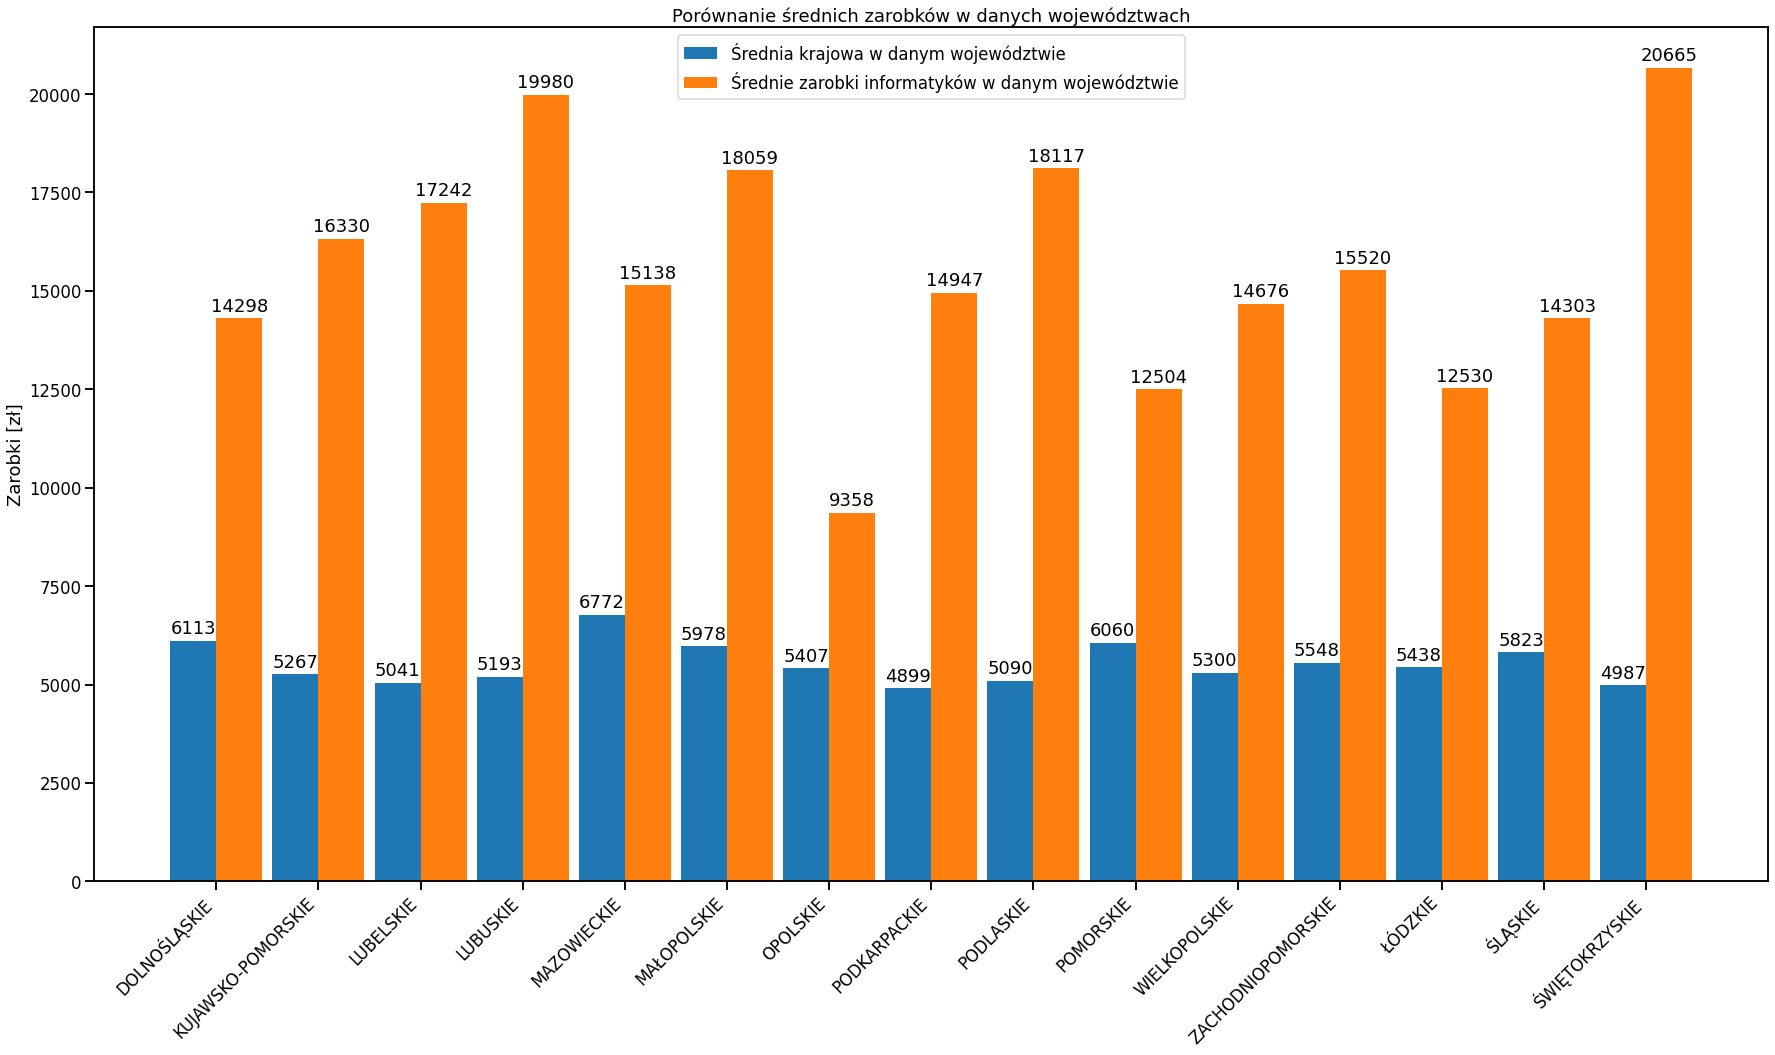

In [142]:
a = []
b = []
c = []

for i in range(0, len(porownanie_srednich_woj_inf['wojewodztwo'])):
    a.append(porownanie_srednich_woj_inf['wojewodztwo'][i])

for i in range(0, len(porownanie_srednich_woj_inf['srednie_zarobki_wojewodztwo'])):
    b.append(porownanie_srednich_woj_inf['srednie_zarobki_wojewodztwo'][i])

for i in range(0, len(porownanie_srednich_woj_inf['srednie_zarobki_inf'])):
    c.append(porownanie_srednich_woj_inf['srednie_zarobki_inf'][i])

import matplotlib.pyplot as plt
import numpy as np


labels = a
men_means = b
women_means = c

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Średnia krajowa w danym województwie')
rects2 = ax.bar(x + width/2, women_means, width, label='Średnie zarobki informatyków w danym województwie')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Zarobki [zł]')
ax.set_title('Porównanie średnich zarobków w danych województwach')
ax.set_xticks(x, labels, rotation=45, ha='right')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.rcParams["figure.figsize"] = (25,15)
plt.show()